# LivePerson Chat Intent Classifier Training
Objective: Design a CNN based NLP algorithm to learn from past mapping of chat contents to Chat Categories 

Author: Wenlian Yu

Date: 09/22/2020

Parameter Tuning Priorities - 
1. change embedding layer to trainable = True. This will allow 2M parameters of GloVe embedding to get trainned with Verizon context. It will cost run time but overall provide a better prediction
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)

2. change MAX_SEQUENCE_LENGTH = 500 to change MAX_SEQUENCE_LENGTH = 1000
3. change MAX_VOCAB_SIZE = 20000 to MAX_VOCAB_SIZE = 40000
4. change BATCH_SIZE = 128 to BATCH_SIZE = 256
5. increase train/validation (true validation sample for scoring, not the one used for cross validation) to 20%/80%
train, rest = chat_text_raw.randomSplit([0.2, 0.8], seed=12345)
6. increase # of Convolution and Maxpooling layers from 3 to 4
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(BATCH_SIZE, activation='relu')(x)
output = Dense(label_cnt, activation='sigmoid')(x)

In [1]:
from pyspark.sql.functions import concat_ws, col, lit
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer,RegexTokenizer,StopWordsRemover
from pyspark.ml import Pipeline
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [2]:
# extract LivePerson Chat text and categorized intent from VMG Hive table source - 
print('Loading in chat text...')
# chat_text_raw=spark.table("qes_prd_qmtbls.wen_lpchat_nlp_sample")
# chat_text_raw=spark.table("qes_prd_qmtbls.wen_lpchat_nlp_sample_agent")
chat_text_raw=spark.table("qes_prd_qmtbls.nina_lpchat_nlp_sample_all")
chat_text_raw.printSchema()

Loading in chat text...
root
 |-- chat_conversation_id: string (nullable = true)
 |-- chat_text_string: string (nullable = true)
 |-- ctgry_driver: string (nullable = true)



In [4]:
# sample down
train, validation = chat_text_raw.randomSplit([0.15, 0.85], seed=12345)

In [5]:
# saving the samples that are not used for training
validation.write.mode("overwrite").format("parquet").save("hdfs:///projects/ova_vz/qes_prd_qmtbls.db/psringam_lp_validation.parquet")
!hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/psringam_lp_validation.parquet

In [ ]:
!hdfs dfs -cp -f /user/wyu03/qes/NLP/Stopword_list.txt /projects/ova_vz/qes_prd_qmtbls.db/Stopword_list.txt
!hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/Stopword_list.txt

In [6]:
# loading stopword list and prepare for tokenization and stopword removal
regextokenizer = RegexTokenizer(inputCol='chat_text_string', outputCol = 'token_sentences',pattern="\\w+",gaps=False)
stopwordList= spark.read.csv("hdfs:///projects/ova_vz/qes_prd_qmtbls.db/Stopword_list.txt", inferSchema=True,header=False)\
                   .toPandas()['_c0'].values.tolist()
# stopwordList= spark.read.csv("hdfs:///projects/ova_vz/qes_prd_qmtbls.db/Stopwords_verizon.txt", inferSchema=True,header=False)\
#                    .toPandas()['_c0'].values.tolist()
stopremove = StopWordsRemover(inputCol='token_sentences',outputCol='stop_token_sentences',stopWords=stopwordList)

In [7]:
# build processing pipeline
data_prep_pipe = Pipeline(stages=[regextokenizer,stopremove])
cleaner = data_prep_pipe.fit(train)
chat_text_cleaned = cleaner.transform(train)

In [8]:
# verify text cleansing is done
chat_text_cleaned.printSchema()

root
 |-- chat_conversation_id: string (nullable = true)
 |-- chat_text_string: string (nullable = true)
 |-- ctgry_driver: string (nullable = true)
 |-- token_sentences: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stop_token_sentences: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [9]:
chat_text_sample = chat_text_cleaned.withColumn("sentence_token_cleansed", concat_ws(" ", "stop_token_sentences"))\
                                    .where(col("chat_text_string").isNotNull())\
                                    .select("chat_conversation_id", "chat_text_string", "sentence_token_cleansed", "ctgry_driver")

In [10]:
# convert to pandas df
train_pd=chat_text_sample.toPandas()
train_pd

,chat_conversation_id,chat_text_string,sentence_token_cleansed,ctgry_driver
0,00079032-83d6-47ac-8e5d-918a3708b458,"Yes even I am checking with the pricing.,Just ...",even checking pricing just minute two gone pla...,CD PLAN Add/Change
1,000cf76d-8591-427f-865a-8911132f410c,"What's your phone number?,Yes,Verizon knows th...",phone number knows challenging time working ad...,CD ACCT Prepay Information
2,0011be30-1f2b-433c-8c15-220d73565a38,"Oh, I see. That's good. Our lowest data plan i...",oh see good lowest data plan actually gb like ...,CD PLAN Inquiry
3,00179209-065c-46b2-9514-8ec7408d79c9,"Verizon**,Thank you very much for understandin...",much understanding ok added item cart using po...,CD ACCT Verizon Up Program
4,001aae5a-440e-4dd7-bac8-b6aeb6d25b37,"Can you try calling out?,It's definitely a har...",try calling definitely hard time pregnant coro...,CD TRBL Voice
...,...,...,...,...
124160,fff5d785-c428-4166-b1f8-a3e63cc3ef33,"Upgrade,Verizon knows that this is a challengi...",upgrade knows challenging time working address...,CD ACCT Insurance (TEC/TMP)
124161,fff89bb9-1c1d-4228-b961-21b12af6b48a,"Manage my account,VZMANAGERBOT* joined the con...",manage account vzmanagerbot joined conversatio...,CD DISC Disconnect
124162,fff95b82-5ea6-4def-893d-df0d64c8a3e1,"Rhnk you,Verizon knows that this is a challeng...",rhnk knows challenging time working address co...,CD ACCT Retail Information
124163,fffa3e16-8370-4e99-b030-98d9906dd96d,we haver a new phone and would like to activsa...,haver new phone like activsate knows challengi...,CD ACCT Service Features


In [ ]:
# chat_text_sample.filter((col("chat_conversation_id") == lit("0000b635-6231-4cc2-8c18-0977bb94aeab")))\
#      .select("sentence_token_cleansed")\
#      .show(truncate=False)

In [ ]:
# spark.stop()

In [11]:
from __future__ import print_function, division
from builtins import range
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Frequency')

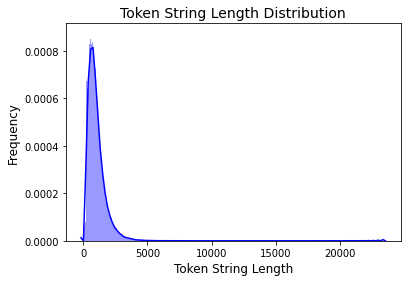

In [60]:
sns.distplot(train_pd['sentence_token_cleansed'].str.len(), kde=True, color='blue', bins=100)
plt.title('Token String Length Distribution', fontsize=14)
plt.xlabel('Token String Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [13]:
import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [14]:
# some configuration
MAX_SEQUENCE_LENGTH = 1500
MAX_VOCAB_SIZE = 40000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 128
EPOCHS = 4000

In [15]:
!cd ./tmp

In [1]:
!ls

container_tokens     oci-layer13  oci-layer24  oci-layer7
hive-site.xml	     oci-layer14  oci-layer25  oci-layer8
jup3.zip	     oci-layer15  oci-layer26  oci-layer9
kernel-268.json      oci-layer16  oci-layer27  private_etc_passwd
kernel.py	     oci-layer17  oci-layer28  private_slash_tmp
launch_container.sh  oci-layer18  oci-layer29  private_var_slash_tmp
oci-config32	     oci-layer19  oci-layer3   py4j-0.10.9-src.zip
oci-layer0	     oci-layer2   oci-layer30  pyspark.zip
oci-layer1	     oci-layer20  oci-layer31  __spark_conf__
oci-layer10	     oci-layer21  oci-layer4   __spark_libs__
oci-layer11	     oci-layer22  oci-layer5   tmp
oci-layer12	     oci-layer23  oci-layer6


In [18]:
!hadoop fs -get -f /projects/ova_vz/qes_prd_qmtbls.db/glove.6B.100d.txt glove.6B.100d.txt

In [19]:
!ls

container_tokens     oci-layer12  oci-layer23  oci-layer6
glove.6B.100d.txt    oci-layer13  oci-layer24  oci-layer7
hive-site.xml	     oci-layer14  oci-layer25  oci-layer8
jup3.zip	     oci-layer15  oci-layer26  oci-layer9
kernel-269.json      oci-layer16  oci-layer27  private_etc_passwd
kernel.py	     oci-layer17  oci-layer28  private_slash_tmp
launch_container.sh  oci-layer18  oci-layer29  private_var_slash_tmp
oci-config32	     oci-layer19  oci-layer3   py4j-0.10.9-src.zip
oci-layer0	     oci-layer2   oci-layer30  pyspark.zip
oci-layer1	     oci-layer20  oci-layer31  __spark_conf__
oci-layer10	     oci-layer21  oci-layer4   __spark_libs__
oci-layer11	     oci-layer22  oci-layer5   tmp


In [ ]:
# !cd ./tmp && hadoop fs -get -f /user/wyu03/qes/NLP/glove.6B.100d.txt glove.6B.100d.txt
# !hdfs dfs -cp -f /user/wyu03/qes/NLP/glove.6B.100d.txt /projects/ova_vz/qes_prd_qmtbls.db/glove.6B.100d.txt
# !hdfs dfs -chmod -R 750 /projects/ova_vz/qes_prd_qmtbls.db/glove.6B.100d.txt
!cd ./tmp && hadoop fs -get -f /projects/ova_vz/qes_prd_qmtbls.db/glove.6B.100d.txt glove.6B.100d.txt

In [21]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
# with open(os.path.join('./tmp/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:      
# is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [ ]:
# values

In [ ]:
# vec

In [ ]:
# word2vec

In [22]:
sentences = train_pd["sentence_token_cleansed"].fillna("DUMMY_VALUE").values
targets = pd.get_dummies(train_pd['ctgry_driver']).values
coding_seq = pd.get_dummies(train_pd['ctgry_driver'])
coding_dict = {coding_seq.columns.get_loc(i):i for i in coding_seq.columns}
label_cnt = len(train_pd.ctgry_driver.unique())
print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 23341
min sequence length: 5
median sequence length: 861


In [ ]:
# save category coding dictionary
# with open('./tmp/LP_category_coding.pickle', 'wb') as handle:
with open('nina_category_coding.pickle', 'wb') as handle:
    pickle.dump(coding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
!ls

container_tokens	     oci-layer12  oci-layer24  oci-layer8
glove.6B.100d.txt	     oci-layer13  oci-layer25  oci-layer9
hive-site.xml		     oci-layer14  oci-layer26  private_etc_passwd
jup3.zip		     oci-layer15  oci-layer27  private_slash_tmp
kernel-269.json		     oci-layer16  oci-layer28  private_var_slash_tmp
kernel.py		     oci-layer17  oci-layer29  py4j-0.10.9-src.zip
launch_container.sh	     oci-layer18  oci-layer3   pyspark.zip
nina_category_coding.pickle  oci-layer19  oci-layer30  __spark_conf__
oci-config32		     oci-layer2   oci-layer31  __spark_libs__
oci-layer0		     oci-layer20  oci-layer4   tmp
oci-layer1		     oci-layer21  oci-layer5
oci-layer10		     oci-layer22  oci-layer6
oci-layer11		     oci-layer23  oci-layer7


In [25]:
!hdfs dfs -put -f nina_category_coding.pickle /projects/ova_vz/qes_prd_qmtbls.db/nina_category_coding.pickle
!hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/nina_category_coding.pickle

In [26]:
sentences

array(['even checking pricing just minute two gone plan need help options options available understand situation like inform charges decreased 17 change plan start unlimited much unlimited right now around 170 lines work home internet keeps outages alright however may know use hotspot feature thanks ok total bill switching unlimited rest assured right hands now cost unlimited ok update like change unlimited contacting us stay safe healthy take care loved ones goodbye also sending next bill summary anything else ok thanks definitely let know congrats changed plan start unlimited current billing now surely save 17 per month next billing ok options correct around 149 thanks much monthly bill decrease 17 month changed unlimited sure thing thanks ok necessary changes right away view plan knows challenging time working address concerns quickly possible received message agent get back soon answer keep mind wait times may longer usual need wait around notified respond ok thanks really apprecia

In [27]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [28]:
with open('nina_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# !cd ./tmp && hdfs dfs -put -f LP_tokenizer.pickle /user/wyu03/qes/NLP/LP_tokenizer.pickle


put: `nina_tokenizer.pickle': No such file or directory
chmod: `/projects/ova_vz/qes_prd_qmtbls.db/nina_tokenizer.pickle': No such file or directory


In [30]:
!hdfs dfs -put -f nina_tokenizer.pickle /projects/ova_vz/qes_prd_qmtbls.db/nina_tokenizer.pickle
!hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/nina_tokenizer.pickle

In [31]:
# sequences

In [32]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 99676 unique tokens.


In [33]:
word2idx

{'may': 1,
 'account': 2,
 'get': 3,
 'need': 4,
 'wait': 5,
 'phone': 6,
 'help': 7,
 'line': 8,
 'not': 9,
 'time': 10,
 'back': 11,
 'agent': 12,
 'working': 13,
 'bill': 14,
 'number': 15,
 'ok': 16,
 'device': 17,
 'just': 18,
 'address': 19,
 'message': 20,
 'received': 21,
 'keep': 22,
 'today': 23,
 'see': 24,
 'concerns': 25,
 'longer': 26,
 'now': 27,
 'possible': 28,
 'plan': 29,
 'answer': 30,
 'times': 31,
 't': 32,
 'mind': 33,
 'around': 34,
 'quickly': 35,
 'respond': 36,
 'soon': 37,
 'challenging': 38,
 'usual': 39,
 'notified': 40,
 'knows': 41,
 'know': 42,
 'thanks': 43,
 'let': 44,
 'new': 45,
 'chat': 46,
 'check': 47,
 'like': 48,
 'want': 49,
 'order': 50,
 'sure': 51,
 'us': 52,
 'make': 53,
 'service': 54,
 'welcome': 55,
 'data': 56,
 'off': 57,
 'still': 58,
 'payment': 59,
 'assist': 60,
 'call': 61,
 'good': 62,
 'able': 63,
 'pay': 64,
 'great': 65,
 'unlimited': 66,
 'okay': 67,
 'go': 68,
 'apple': 69,
 'also': 70,
 'information': 71,
 'month': 72,
 'm

In [34]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (124165, 1500)


In [35]:
data

array([[    0,     0,     0, ...,     4,   335,  1462],
       [    0,     0,     0, ...,   217,     7,   949],
       [    0,     0,     0, ...,   122,    72,   529],
       ...,
       [    0,     0,     0, ...,   810, 18036,    55],
       [    0,     0,     0, ...,   448,    95,    76],
       [    0,     0,     0, ...,    71,    96,   119]], dtype=int32)

In [36]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [37]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.082528  , -0.07529   ,  0.014696  , ..., -0.92017001,
         0.36851999, -0.38653001],
       [-0.043476  ,  0.086186  ,  0.43744999, ..., -0.78872001,
         0.13494   ,  0.074029  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)

In [39]:
embedding_layer

In [40]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(BATCH_SIZE, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(BATCH_SIZE, activation='relu')(x)
output = Dense(label_cnt, activation='sigmoid')(x)

Building model...


In [41]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
#   loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [42]:
print('Training model...')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  callbacks=[es]
)

Training model...


/tmp/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 86915 samples, validate on 37250 samples
Epoch 1/4000
86915/86915 [==============================] - 138s 2ms/step - loss: 0.0372 - accuracy: 0.9908 - val_loss: 0.0275 - val_accuracy: 0.9928
Epoch 2/4000
86915/86915 [==============================] - 140s 2ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0138 - val_accuracy: 0.9960
Epoch 3/4000
86915/86915 [==============================] - 138s 2ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0106 - val_accuracy: 0.9970
Epoch 4/4000
86915/86915 [==============================] - 145s 2ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch 5/4000
86915/86915 [==============================] - 146s 2ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0097 - val_accuracy: 0.9973
Epoch 6/4000
86915/86915 [==============================] - 147s 2ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0125 - val_accuracy: 0.9969
Epoch 00006: early stopping


In [43]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1500)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1500, 100)         4000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1498, 128)         38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 497, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 165, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 163, 128)          4928

In [44]:
# model.summary()
model.get_weights()
# model.optimizer

[array([[-6.57024011e-02,  2.98559181e-02,  1.15613855e-01, ...,
         -2.82199699e-02,  6.83446303e-02,  1.26251817e-01],
        [ 7.09493458e-02, -9.37765911e-02,  2.42334921e-02, ...,
         -8.55739355e-01,  3.44413072e-01, -3.96557689e-01],
        [ 1.06520750e-01,  2.98709005e-01,  4.51197267e-01, ...,
         -7.46158898e-01,  2.73024347e-02,  1.90244421e-01],
        ...,
        [ 2.34613148e-03,  2.79962202e-03,  1.30683109e-02, ...,
          1.53219793e-02,  5.47557371e-03, -1.35241384e-02],
        [-8.66494724e-04, -1.14016421e-03, -1.10951089e-03, ...,
         -2.47384654e-04, -9.86607629e-04,  1.15087489e-03],
        [-5.34439040e-03, -1.80323292e-02, -1.56213418e-02, ...,
         -4.90104314e-04,  2.88398121e-03,  1.55365821e-02]], dtype=float32),
 array([[[-1.61144122e-01, -4.41556703e-03,  5.81254996e-02, ...,
          -3.79491784e-02,  8.37009773e-02,  2.42578790e-01],
         [ 9.05966088e-02, -1.81272283e-01, -3.10757775e-02, ...,
          -7.1385338

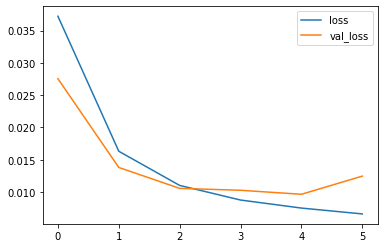

In [45]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [46]:
print(r.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


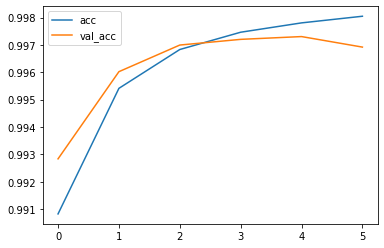

In [47]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [48]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(12):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.977699599594982


In [50]:
model.save('nina_chat_intent_model.h5')
# !cd ./tmp && hadoop fs -put -f LP_chat_intent_model.h5 /user/wyu03/qes/NLP/LP_chat_intent_model.h5
!hdfs dfs -put -f nina_chat_intent_model.h5 /projects/ova_vz/qes_prd_qmtbls.db/nina_chat_intent_model.h5
!hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/nina_chat_intent_model.h5
del model 

# !cd ./tmp && hdfs dfs -get -f /user/wyu03/qes/NLP/LP_chat_intent_model.h5 LP_chat_intent_model.h5 
!hdfs dfs -get -f /projects/ova_vz/qes_prd_qmtbls.db/nina_chat_intent_model.h5 
model = load_model('nina_chat_intent_model.h5')

container_tokens	     oci-layer10  oci-layer22  oci-layer6
glove.6B.100d.txt	     oci-layer11  oci-layer23  oci-layer7
hive-site.xml		     oci-layer12  oci-layer24  oci-layer8
jup3.zip		     oci-layer13  oci-layer25  oci-layer9
kernel-269.json		     oci-layer14  oci-layer26  private_etc_passwd
kernel.py		     oci-layer15  oci-layer27  private_slash_tmp
launch_container.sh	     oci-layer16  oci-layer28  private_var_slash_tmp
nina_category_coding.pickle  oci-layer17  oci-layer29  py4j-0.10.9-src.zip
nina_chat_intent_model.h5    oci-layer18  oci-layer3   pyspark.zip
nina_tokenizer.pickle	     oci-layer19  oci-layer30  __spark_conf__
oci-config32		     oci-layer2   oci-layer31  __spark_libs__
oci-layer0		     oci-layer20  oci-layer4   tmp
oci-layer1		     oci-layer21  oci-layer5


In [53]:
# model.summary()
model.get_weights()
# model.optimizer

[array([[-6.57024011e-02,  2.98559181e-02,  1.15613855e-01, ...,
         -2.82199699e-02,  6.83446303e-02,  1.26251817e-01],
        [ 7.09493458e-02, -9.37765911e-02,  2.42334921e-02, ...,
         -8.55739355e-01,  3.44413072e-01, -3.96557689e-01],
        [ 1.06520750e-01,  2.98709005e-01,  4.51197267e-01, ...,
         -7.46158898e-01,  2.73024347e-02,  1.90244421e-01],
        ...,
        [ 2.34613148e-03,  2.79962202e-03,  1.30683109e-02, ...,
          1.53219793e-02,  5.47557371e-03, -1.35241384e-02],
        [-8.66494724e-04, -1.14016421e-03, -1.10951089e-03, ...,
         -2.47384654e-04, -9.86607629e-04,  1.15087489e-03],
        [-5.34439040e-03, -1.80323292e-02, -1.56213418e-02, ...,
         -4.90104314e-04,  2.88398121e-03,  1.55365821e-02]], dtype=float32),
 array([[[-1.61144122e-01, -4.41556703e-03,  5.81254996e-02, ...,
          -3.79491784e-02,  8.37009773e-02,  2.42578790e-01],
         [ 9.05966088e-02, -1.81272283e-01, -3.10757775e-02, ...,
          -7.1385338

In [54]:
# checking coding dictionary
coding_dict

{0: 'CD ACCT Account Manager',
 1: 'CD ACCT Add a Line/New Activation',
 2: 'CD ACCT Address/Email/ Name/Contact Update',
 3: 'CD ACCT Assumption of Liability',
 4: 'CD ACCT Billing System Password',
 5: 'CD ACCT Call Message Block',
 6: 'CD ACCT Change MTN',
 7: 'CD ACCT Connected Car',
 8: 'CD ACCT Consumer Privacy Act',
 9: 'CD ACCT Corporate Information',
 10: 'CD ACCT Family Controls/Family Base',
 11: 'CD ACCT Fios Information',
 12: 'CD ACCT Fraud',
 13: 'CD ACCT Informational',
 14: 'CD ACCT Insurance (TEC/TMP)',
 15: 'CD ACCT Lost/Stolen/Damaged',
 16: 'CD ACCT My VZW/My VZ Mobile',
 17: 'CD ACCT Non VZW Customer Call',
 18: 'CD ACCT Notification Letter/Email/Text/Call',
 19: 'CD ACCT Port Status',
 20: 'CD ACCT Prepay Information',
 21: 'CD ACCT Retail Information',
 22: 'CD ACCT Service Features',
 23: 'CD ACCT Smart Rewards',
 24: 'CD ACCT Spam/Spoof',
 25: 'CD ACCT Suspend/Reconnect',
 26: 'CD ACCT Verizon Up Program',
 27: 'CD ACCT Verizon Visa Card',
 28: 'CD ACCT Winbac

In [ ]:
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/glove.6B.100d.txt
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/wyu_lp_validation.parquet
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/Stopword_list.txt

# !hdfs dfs -cp -f /user/wyu03/qes/NLP/Stopwords_verizon.txt /projects/ova_vz/qes_prd_qmtbls.db/Stopwords_verizon.txt
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/Stopwords_verizon.txt

# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/LP_chat_intent_model.h5
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/LP_tokenizer.pickle
# !hdfs dfs -chmod -R 755 /projects/ova_vz/qes_prd_qmtbls.db/LP_category_coding.pickle